In [1]:
import harp
import utils
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from functools import reduce
import aeon.io.video as video
import aeon.analysis.movies as frame_helpers
import cv2
import numpy as np

harp_reader = harp.create_reader('device.yml', epoch=harp.REFERENCE_EPOCH)
session_data_reader = utils.SessionData()
rules_reader = utils.SessionData()
video_reader = utils.Video()

harp_datafolder = r'../temp_data/2024-02-20T18-47-30/Expander/'
settings_datafolder = r'../temp_data/2024-02-20T18-47-30/SessionSettings/'
rules_datafolder = r'../temp_data/2024-02-20T18-47-30/RuleSettings/'
video_datafolder = r'../temp_data/2024-02-20T18-47-30/VideoData/'

In [2]:
# read experiment metadata
session_settings = utils.load_json(session_data_reader, settings_datafolder)

rule_settings = utils.load_json(rules_reader, rules_datafolder)

print(session_settings)
print(rule_settings)

                                                                     metadata
2024-02-20 18:47:30.398591  {'lineMappings': {'odorMap': [DotMap(name='Odo...
                                                                     metadata
2024-02-20 18:47:30.398591  {'ruleAlias': 'Rule1', 'stateDefinitions': [{'...


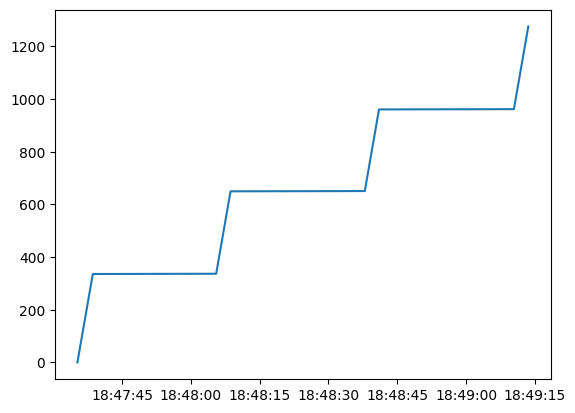

In [3]:
# read experiment video
video_data = utils.load_video(video_reader, video_datafolder)

plt.plot(video_data.index, video_data["_frame"])

In [4]:
# Read HARP device streams, conditioned on mappings found in the session metadata
metadata = session_settings.iloc[0]['metadata']
print(metadata)

# Extract line mappings from metadata
aux_line = f'Aux{metadata.lineMappings.auxLine}'
port_line = f'Out{metadata.lineMappings.portLine}'
vacuum_line = f'Out{metadata.lineMappings.vacuumLine}'
odorA = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorA'), None)}"
odorB = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorB'), None)}"
odorC = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorC'), None)}"
odorD = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorD'), None)}"

# Aux line containing poke events
poke_events = utils.load(harp_reader.AuxInState, harp_datafolder)[aux_line]

# times when outputs were set to HIGH (e.g. port valve opening, manifold valve opening)
outputs_HIGH = utils.load(harp_reader.OutputSet, harp_datafolder)
# times when outputs were set to LOW (e.g. port valve closing, manifold closing)
outputs_LOW = utils.load(harp_reader.OutputClear, harp_datafolder)

# convert LOW and HIGH events to port state dataframes
line_states = {
    "poke_events": poke_events,
    "port_line_state": utils.concat_digi_events(outputs_LOW[port_line], outputs_HIGH[port_line]),
    "vacuum_line_state": utils.concat_digi_events(outputs_LOW[vacuum_line], outputs_HIGH[vacuum_line]),
    "odorA_state": utils.concat_digi_events(outputs_LOW[odorA], outputs_HIGH[odorA]),
    "odorB_state": utils.concat_digi_events(outputs_LOW[odorB], outputs_HIGH[odorB]),
    "odorC_state": utils.concat_digi_events(outputs_LOW[odorC], outputs_HIGH[odorC]),
    "odorD_state": utils.concat_digi_events(outputs_LOW[odorD], outputs_HIGH[odorD])
}

# consolidate digital lines into as single DataFrame
merged = pd.merge(line_states["poke_events"], line_states["port_line_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["vacuum_line_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorA_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorB_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorC_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorD_state"], left_on="Time", right_on="Time", how="outer")

# rename columns according to metadata line mapping
merged.columns = line_states.keys()

# 

DotMap(lineMappings=DotMap(odorMap=[DotMap(name='OdorA', line=6), DotMap(name='OdorB', line=7), DotMap(name='OdorC', line=8), DotMap(name='OdorD', line=9)], portLine=0, vacuumLine=2, auxLine=0), metadata=DotMap(animalId='plimbo', loggingRootPath='C:\\Users\\Delphi1983\\Delphi\\temp_data\\', remoteTransferRootPath='', chargeTime=0.2, minimumPokeTime=0.01, maximumPokeTime=10.0, robocopyTimeInterval=3600.0, showHarpLeds=False, maxVideoLength=20.0, minOdorDelivery=0.1, maxOdorDelivery=8.0, switchTime1=0.01, switchTime2=0.02, vacuumDelay=0.005, vacuumDuration=0.05, useVacuum=False), cameraProperties=DotMap(imagingRate=100.0, preEventTime=2.5, postEventTime=2.5))


C:\Users\erski\AppData\Local\Temp\ipykernel_9608\937734368.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.plot(event_data["port_line_state"].ffill() + 1.1, drawstyle = 'steps-post')
C:\Users\erski\AppData\Local\Temp\ipykernel_9608\937734368.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_state = event_data.ffill()[event_data.index <= poke_event_time].iloc[[-1]]


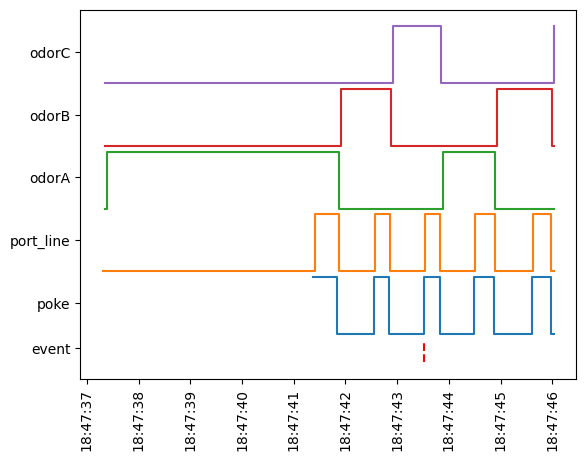

In [5]:
# Using the consolidated data sets, do an example plot centered around a poke event

# Get all the poke onset events, then index to pick a single event. Ultimately we just need to choose a timestamp value to center our plot around.
poke_event_time = merged["poke_events"][merged["poke_events"]==True].index[2] # as an example we here pick the time 3rd poke event time

# Create a time window around the time of this event
time_offset = 10 # 10 second time offset around the event
start_time = poke_event_time - pd.Timedelta(seconds=time_offset)
end_time = poke_event_time + pd.Timedelta(seconds=time_offset)

# Slice the data in this time window
event_data = merged[start_time : end_time]

# Construct a plot of this time window
fig= plt.figure()

plt.plot([poke_event_time, poke_event_time], [-0.5, -0.1], c='r', linestyle='dashed')
plt.plot(event_data["poke_events"].ffill(), drawstyle = 'steps-post')
plt.plot(event_data["port_line_state"].ffill() + 1.1, drawstyle = 'steps-post')
plt.plot(event_data["odorA_state"].ffill() + 2.2, drawstyle = 'steps-post')
plt.plot(event_data["odorB_state"].ffill() + 3.3, drawstyle = 'steps-post')
plt.plot(event_data["odorC_state"].ffill() + 4.4, drawstyle = 'steps-post')
plt.xticks(rotation=90)

ax = fig.axes[0]
ax.set_yticks([-0.25, 0.55, 1.65, 2.75, 3.85, 4.95])
ax.set_yticklabels(['event', 'poke', 'port_line', 'odorA', 'odorB', 'odorC'])

# extract other information about this event
current_rule = rule_settings[rule_settings.index <= poke_event_time]["metadata"].iloc[[-1]]
current_state = event_data.ffill()[event_data.index <= poke_event_time].iloc[[-1]] 

on_odors = [odor_name for odor_name in ['odorA_state', 'odorB_state', 'odorC_state'] if current_state[odor_name].values[0]]